## Import Packages

In [1]:
import rdkit
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn import neighbors
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import metrics 

## Read files and create dataframe with Smiles

In [2]:
df_smiles1 = pd.read_csv('tested_molecules.csv')
df_smiles2 = pd.read_csv('tested_molecules_v2.csv')
df_test_smiles = pd.read_csv('untested_molecules.csv')
df_smiles = pd.concat([df_smiles1, df_smiles2], ignore_index=True)
print(df_smiles)

                                                 SMILES  ALDH1_inhibition
0     COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...                 1
1                O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1                 1
2     Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...                 1
3                     CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1                 1
4     CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21                 1
...                                                 ...               ...
1995                    C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1                 1
1996                     COC(=O)c1c(NC(C)=O)sc2c1CCCCC2                 1
1997                            O=C(CCl)NC1CCCc2ccccc21                 1
1998    COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1                 1
1999  COc1ccc(NC(=O)C2CCC(N3C(=O)C4C5C=CC(C5)C4C3=O)...                 1

[2000 rows x 2 columns]


## Check descriptor values for all Smiles

In [3]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [4]:
allDescrs = []
for _, row in df_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_descr = pd.DataFrame(allDescrs)
df_descr.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,-0.683140,13.083531,0.001173,0.520365,463.542,434.310,463.233188,178,0,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,-0.066966,12.170097,0.066966,0.498564,378.457,360.313,378.115047,136,0,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,-0.016881,10.905837,0.016881,0.382043,477.589,444.325,477.260865,184,0,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,-0.454447,11.562446,0.270607,0.795948,330.609,317.505,328.981818,96,0,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,-3.251317,12.108866,0.086947,0.687618,419.553,402.417,419.043204,140,0,...,0,1,0,0,0,1,0,1,0,0


## Data cleaning

Delete the collumns that have only one unique value, so a column where each value is the mean, and variance is 0

In [49]:
#Deletes colums with nonsense values (only the same values)
bad_descr=[]
for i in df_descr.columns:
    if df_descr[i].nunique() == 1:
        bad_descr.append(i)
print(bad_descr)       
df_nonzero=df_descr.drop(columns=bad_descr)  

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_HOCCN', 'fr_azide', 'fr_benzodiazepine', 'fr_diazo', 'fr_isocyan', 'fr_isothiocyan', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd']


Remove variables so that no variables are left that have a hcorralation with another variable higher than the set threshold for corralation

In [50]:
corrThreshold = 0.90


correlation_mat = df_nonzero.corr()
upper_tri = correlation_mat.where(np.triu(np.ones(correlation_mat.shape),k=1).astype(bool)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > corrThreshold)] 
df_noCorr = df_nonzero.drop(columns=to_drop)



df_noCorr.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,-0.683140,0.001173,0.520365,463.542,0.249868,-0.496477,1.088235,16.465857,10.012387,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,-0.066966,0.066966,0.498564,378.457,0.230353,-0.467476,1.111111,32.166556,10.202245,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,-0.016881,0.016881,0.382043,477.589,0.219930,-0.492903,1.228571,16.492058,9.989823,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,-0.454447,0.270607,0.795948,330.609,0.351723,-0.421732,1.333333,79.918731,10.173315,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,-3.251317,0.086947,0.687618,419.553,0.231765,-0.301646,1.296296,32.233291,10.071048,...,0,1,0,0,0,1,0,1,0,0


## Scale data & perform PCA

In [51]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_noCorr)

pca = PCA(n_components=48)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

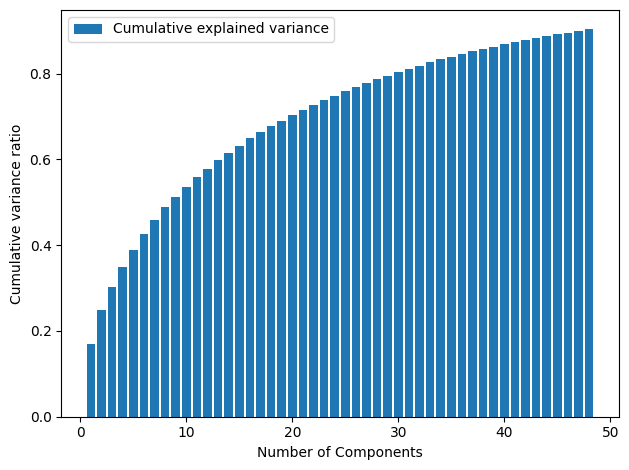

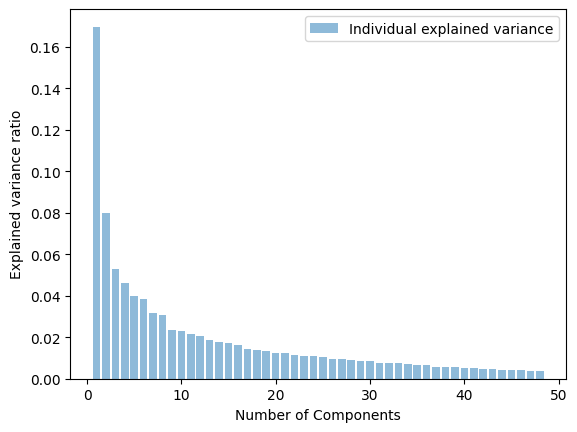

In [52]:
plt.bar(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, align='center',label='Cumulative explained variance');
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#scree plot om aantal PCA te bepalen
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance');
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.show()

In [53]:
#verwijderen van features die lage variance hebben
#x is hierbij je matrix met alle features.

selection = VarianceThreshold(threshold=(.8*(1-.8)))
df_noCorr = selection.fit_transform(df_noCorr)
selection

VarianceThreshold(threshold=0.15999999999999998)

## Split data for testing

In [54]:
features = np.array(principalDf)
feature_names = list(principalDf.columns)
target = np.array(df_smiles['ALDH1_inhibition'])

### Training & test set

In [55]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.20, random_state = 42)

#check the shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1600, 48)
Training Labels Shape: (1600,)
Testing Features Shape: (400, 48)
Testing Labels Shape: (400,)


## Predictor models

### Random Forest Regressor Model

In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

Predictions

In [13]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [14]:
def get_labels(threshold, predictions):
    " Classify the predictions in category 1 or 0, based on the given threhold parameters"
    predicted_labels = []
    for i in predictions:
        if i>= threshold:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    return  predicted_labels

In [15]:
# Get the labels from the predictions
rf_predicted_labels = get_labels(0.5, predictions)

In [16]:
# Calculate the balanced accuracy
d={'predictions':predictions, 'predicted_labels':rf_predicted_labels, 'true_labels':test_labels}
rf_results = pd.DataFrame(d) 
#print(rf_results)
rf_acc = metrics.balanced_accuracy_score(rf_results['true_labels'], rf_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(rf_results['true_labels'], rf_results['predicted_labels']).ravel()
cm = confusion_matrix(rf_results['true_labels'], rf_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('Predicted label',fontsize=13)
plt.xlabel('True label',fontsize=13)
plt.title('RF confusion Matrix',fontsize=17)
plt.show()

accuracy 0.7327380952380952
specificity 0.8571428571428571
sensitivity 0.6083333333333333


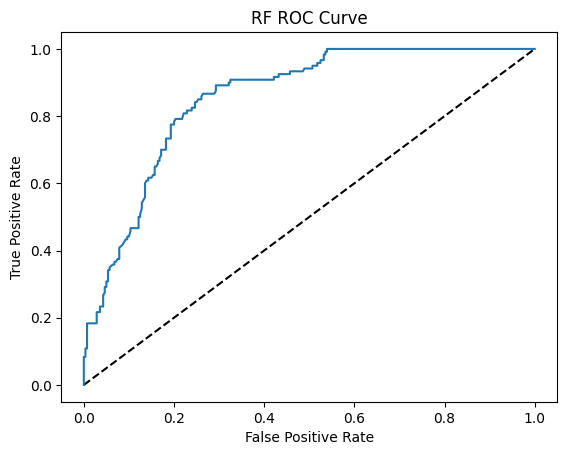

In [18]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(rf_results['true_labels'], rf_results['predictions'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve')
plt.show()

### Random Forest Classifier Model

In [19]:
clf=RandomForestClassifier()
clf.fit(train_features, train_labels)

RandomForestClassifier()

Predictions

In [20]:
preds = clf.predict(test_features)
print ("accuracy of the training set",clf.score(train_features, train_labels))
print("accuracy of the test set" ,clf.score(test_features, test_labels))

rf_acc = metrics.balanced_accuracy_score(test_labels, preds)
print(rf_acc)

accuracy of the training set 1.0
accuracy of the test set 0.7775
0.6767857142857143


## Support vector machine

### Support vector regressor

In [21]:
# Make a default SVR model and calculate the labels from the predictions
SVR_model_default = SVR()
SVR_model_default.fit(train_features, train_labels)
y_pred_SVR_default = SVR_model_default.predict(test_features)
svr_predicted_labels = get_labels(0.5, y_pred_SVR_default)
#print(y_pred_SVR_default)

In [22]:
# Calculate the balanced accuracy
d={'predictions':y_pred_SVR_default, 'predicted_labels':svr_predicted_labels, 'true_labels':test_labels}
svr_default_results = pd.DataFrame(d) 
print(svr_default_results)

svr_default_acc = metrics.balanced_accuracy_score(svr_default_results['true_labels'], svr_default_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(svr_default_results['true_labels'], svr_default_results['predicted_labels']).ravel()
cm = confusion_matrix(svr_default_results['true_labels'], svr_default_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('Predicted label',fontsize=13)
plt.xlabel('True label',fontsize=13)
plt.title('SVM confusion Matrix',fontsize=17)
plt.show()

     predictions  predicted_labels  true_labels
0       0.548571                 1            1
1       0.097966                 0            0
2      -0.081198                 0            0
3       0.127078                 0            0
4       0.022477                 0            0
..           ...               ...          ...
395     0.057733                 0            0
396    -0.029154                 0            0
397     0.885704                 1            1
398     0.796594                 1            1
399     0.009468                 0            0

[400 rows x 3 columns]
accuracy 0.6767857142857143
specificity 0.8678571428571429
sensitivity 0.6416666666666667


In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(svr_default_results['true_labels'], svr_default_results['predicted_labels'] )
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

In [23]:
# Define the parameter values used in GridSearch for the optimized model
estimator_SVR = SVR(gamma = 'auto')
parameters_SVR = {
    'C':(0.1,1, 10, 100), 
    'kernel': ('linear', 'poly', 'rbf'),
    'coef0': (0.0, 10.0, 1.0)}   

In [24]:
# Find the optimal parameter values
grid_search_SVR = GridSearchCV(
    estimator=estimator_SVR,
    param_grid=parameters_SVR,
    scoring = 'balanced_accuracy',
    n_jobs = -1,
    cv = 5
)

In [25]:
# Fit the model
SVR_1 = grid_search_SVR.fit(train_features, train_labels)
y_pred_SVR1 = SVR_1.predict(test_features)
svr1_predicted_labels = get_labels(0.5, y_pred_SVR1)

C:\Users\20192059\.conda\envs\adv_programming\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [26]:
# Calculate the balanced accuracy
d={'predictions':y_pred_SVR1, 'predicted_labels':svr1_predicted_labels, 'true_labels':test_labels}
svr_optimized_results = pd.DataFrame(d) 
#print(svr_optimized_results)

svr_optimized_acc = metrics.balanced_accuracy_score(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels']).ravel()
cm = confusion_matrix(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('Predicted label',fontsize=13)
plt.xlabel('True label',fontsize=13)
plt.title('SVM confusion Matrix',fontsize=17)
plt.show()

accuracy 0.6767857142857143
specificity 0.8892857142857142
sensitivity 0.48333333333333334


In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

### Support vector classifier

Make SVM model without optimizing the hyperparameters

In [27]:
SVC_model_default = SVC()
SVC_model_default.fit(train_features, train_labels)
y_pred_SVC_default =SVC_model_default.predict(test_features)

Define the parameter values used in GridSearch

In [28]:
estimator_SVM = SVC(gamma = 'auto')
parameters_SVM = {
    'C':(0.1,1, 10, 100), #(0.1, 15.0, 0.1)
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'coef0': (0.0, 10.0, 1.0),
    'shrinking': (True, False)}   

Find the optimal parameter values 

In [29]:
grid_search_SVM = GridSearchCV(
    estimator=estimator_SVM,
    param_grid=parameters_SVM,
    scoring = 'balanced_accuracy',
    n_jobs = -1,
    cv = 5
)

Fit the model

In [30]:
SVM_1 = grid_search_SVM.fit(train_features, train_labels)
y_pred_SVM1 = SVM_1.predict(test_features)

Evaluate the performance

In [31]:
default_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVC_default)
optimized_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVM1)
print(default_acc)
print(optimized_acc)

0.7732142857142857
0.7619047619047619


## K-nearest Neighbor

### K-nearest Neighbor regressor

In [56]:
# Make the KN model and train it
KN_reg = neighbors.KNeighborsRegressor(n_neighbors=5)
KN_reg.fit(train_features, train_labels)

KNeighborsRegressor()

In [57]:
# Get the predictions on the test set and determine the labels of these predictions
KN_pred = KN_reg.predict(test_features)
KN_predicted_labels = get_labels(0.5, KN_pred)

accuracy 0.7619047619047619
specificity 0.8571428571428571
sensitivity 0.6666666666666666


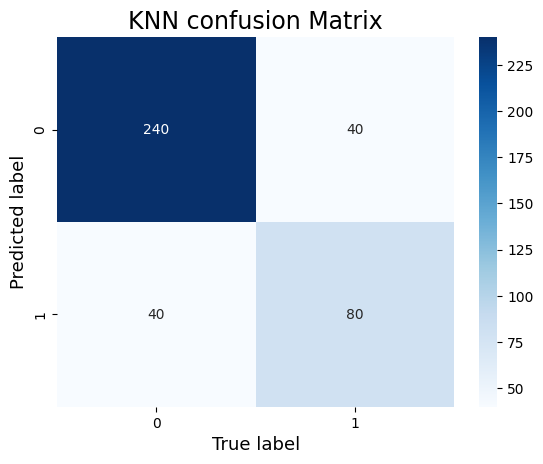

In [58]:
# Calculate the accuracy
d={'predictions':KN_pred, 'predicted_labels':KN_predicted_labels, 'true_labels':test_labels}
kn_results = pd.DataFrame(d) 
#print(kn_results)

kn_acc = metrics.balanced_accuracy_score(kn_results['true_labels'], kn_results['predicted_labels'] )
print("accuracy", kn_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(kn_results['true_labels'], kn_results['predicted_labels']).ravel()
cm = confusion_matrix(kn_results['true_labels'], kn_results['predicted_labels'])
specificity = tn / (tn+fp)
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('Predicted label',fontsize=13)
plt.xlabel('True label',fontsize=13)
plt.title('KNN confusion Matrix',fontsize=17)
plt.show()

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(kn_results['true_labels'], kn_results['predicted_labels'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

### K-nearest Neighbor classifier

In [35]:
KN_clf=neighbors.KNeighborsClassifier(n_neighbors=5)
KN_clf.fit(train_features, train_labels)

KNeighborsClassifier()

Predictions

In [36]:
KN_preds = KN_clf.predict(test_features)
#print(KN_preds)
print ("accuracy of the training set",KN_clf.score(train_features, train_labels))
print("accuracy of the test set" ,KN_clf.score(test_features, test_labels))

default_acc = metrics.balanced_accuracy_score(test_labels, KN_preds)
print("Default accuracy of the test set",default_acc)

accuracy of the training set 0.8425
accuracy of the test set 0.805
Default accuracy of the test set 0.7678571428571429


### Results on test set

### Get descriptors

In [40]:
allDescrs = []
for _, row in df_test_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_test_descr = pd.DataFrame(allDescrs)

### Clean data

In [41]:
df_test_nonzero = df_test_descr.drop(columns=bad_descr)
df_test_noCorr = df_test_nonzero.drop(columns=to_drop)

### PCA

In [59]:
df_test_scaled = scaler.fit_transform(df_test_noCorr)
principalComponents = pca.fit_transform(df_test_scaled)
principalDf_test = pd.DataFrame(data = principalComponents)
print(principalDf_test)

            0         1         2         3         4         5         6   \
0    -0.027180  0.006207 -0.018870  0.108621 -0.657436 -0.184477  0.077628   
1     0.798532 -0.028161 -0.146570 -0.289416 -0.431090  0.414881 -0.311194   
2     0.625495  0.081986 -0.452687  0.085414 -0.015140 -0.306461  0.053523   
3     0.289732  0.137782 -0.369865  0.233838 -0.043964 -0.406724  0.034127   
4     0.229678 -0.276198 -0.363784 -0.525945  0.241544  0.005570  0.449738   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.320934 -0.430322 -0.182991 -0.224949  0.313749 -0.526820  0.259713   
9996  1.198756 -0.085709 -0.422866 -0.051044  0.395642 -0.710226  0.311179   
9997  0.609103  0.466741  0.083630 -0.418290 -0.034965  0.673064  0.179832   
9998 -0.137764 -0.766174  0.282166  0.633671  0.510600  0.282786  0.291628   
9999  0.794696  0.483594 -0.456958 -0.214241 -0.337018  0.330462  0.073645   

            7         8         9   ...        38        39    

### Get predictions

In [65]:
test_features = np.array(principalDf_test)
KN_pred_test = KN_reg.predict(test_features)
test_labels = get_labels(0.5, KN_pred_test)

### Get 100 best molecules

In [66]:
to_be_predicted = 100 #test_labels.sum() #100 in geval van assignment

d={'SMILES':df_test_smiles['SMILES'],'predictions':test_labels}
best_scores = pd.DataFrame(d).nlargest(to_be_predicted,columns='predictions')
print(best_scores)
best_scores.to_csv('best_smiles.csv')

                                                SMILES  predictions
1    Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...            1
3    Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...            1
4              NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1            1
5    CC1(C)CC(=O)C2=C(C1)OC([NH3+])=C(C#N)[C@@]21C(...            1
7    O=C(c1ccc(S(=O)(=O)N2CCCCCC2)cc1)N1CCN(c2ccccn...            1
..                                                 ...          ...
472             O=C(COC(=O)C1(c2ccccc2F)CCCC1)N1CCOCC1            1
473        CN(C)c1ccc(/C=C2\NC(=S)N(Cc3ccccc3)C2=O)cc1            1
474  COc1ccc(N(C)S(=O)(=O)c2ccc(C)cc2)c([N+](=O)[O-...            1
482           Cc1ccc(N2C(=O)CS(=O)C(c3ccccc3)C2=O)cc1C            1
483  O=C(NCCNC1=NS(=O)(=O)c2ccccc21)c1ccc(S(=O)(=O)...            1

[100 rows x 2 columns]


PermissionError: [Errno 13] Permission denied: 'best_smiles.csv'